In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline

import os

In [3]:
#Load Pickles
review1_df = pd.read_pickle('./review1_df.pkl')
business_df = pd.read_pickle('./business_df.pkl')
user_df = pd.read_pickle('./user_df.pkl')

In [6]:
list(business_df)

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [7]:
list(user_df)

['average_stars', 'friends', 'name', 'review_count', 'useful', 'user_id']

In [4]:
#Filter Businesses
business_df = business_df[business_df['categories'].str.contains('Restaurants|Food',na=False)]

In [5]:
#Businesses we care about
biz_df = business_df[business_df['city']=='Toronto']
biz_df = biz_df[biz_df['review_count'] > 5]

In [6]:
#Form Time Series
ts = {b:[] for b in biz_df['business_id']}
for row in review1_df.itertuples(index=True):
    if row.business_id in ts.keys():
        ts[row.business_id].append((row.date.year,row.date.month,row.stars))

In [7]:
for k in list(ts.keys()):
    if ts[k] == []:
        del ts[k]

In [8]:
#Category dictionary
cat = {}
for row in business_df.itertuples(index=True):
    i = row.business_id
    if i not in ts.keys():
        continue
    for c in row.categories.split(', '):
        if c not in cat.keys():
            cat[c] = [i]
        else:
            cat[c].append(i)

In [9]:
#Time series for number of reviews
def make_ts(tpls,time_series):
    min_yr = min(i for i,_,_ in tpls)
    organized = {}
    for y,m,s in tpls:
        key = (y-min_yr)*12 + m
        if key not in organized.keys():
            organized[key] = 0#[]
        organized[key] = organized[key] + 1#.append(s)
    for key in organized.keys():
        time_series[key-1] = organized[key]
    #for key in range(min(organized.keys()),max(organized.keys())+1):
    #    if key in organized.keys():
    #        time_series.append(organized[key])#np.mean(organized[key]))
    #    else:
    #        time_series.append(0)#time_series[-1])
    #time_series = np.array(time_series)
    #time_series = np.append(np.zeros(min(organized.keys()) - 1), time_series)
    return time_series

In [17]:
#Time series for number of reviews
def make_yearly_ts(tpls):
    time_series = np.zeros(12)
    yrs_counted = {i:set() for i in range(0,12)}
    for y,m,s in tpls:
        if y == 2018: continue
        time_series[m-1] += 1
        yrs_counted[m-1].add(y)
    #return [time_series[i] / len(tpls) for i in range(0,12)]
    rslt = [time_series[i] / max(len(yrs_counted[i]),1) for i in range(0,12)] #Corrects for divide by zero
    return rslt

In [100]:
#Makes the initial time series across all years
min_yr = 2018
max_dt = 0
for rev in ts.values():
    for yr,m,_ in rev:
        key = yr*12 + m
        if yr < min_yr:
            min_yr = yr
        if key > max_dt:
            max_dt = key
initial_ts = np.zeros(max_dt - min_yr*12)

In [38]:
time_series = {}
for key,val in ts.items():
    time_series[key] = make_yearly_ts(val)

In [39]:
cat_ts = {}
for key,bizs in cat.items():
    if len(bizs) <= 3: continue
    if key not in cat_ts.keys():
        cat_ts[key] = np.zeros(12)
    for biz in bizs:
        cat_ts[key] = cat_ts[key] + time_series[biz]
    cat_ts[key] = cat_ts[key]

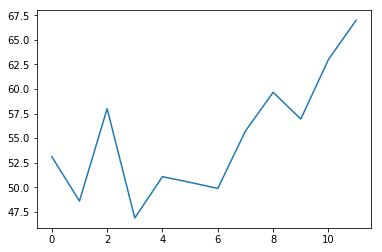

In [26]:
plt.plot(cat_ts['Ramen'])

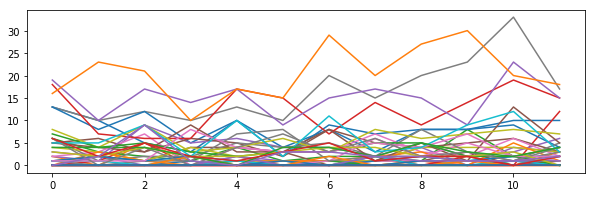

In [140]:
plt.figure(figsize=(10,3))
for biz in cat['Ramen']:
    plt.plot(time_series[biz])

In [55]:
G_ts = nx.Graph()
G_ts.add_nodes_from(cat_ts.keys())

In [56]:
import itertools
import warnings

In [57]:
for a,b in itertools.combinations(G_ts.nodes, 2):
    tsa,tsb = cat_ts[a],cat_ts[b]
    min_len = min(len(tsa),len(tsb))
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            coeff = np.corrcoef(tsa[:min_len],tsb[:min_len])[0,1]
        except:
            coeff = 0
    if coeff > 0.75:
        #plt.subplot(2,1,1)
        #plt.plot(time_series[a][:min_len])
        #plt.subplot(2,1,2)
        #plt.plot(time_series[b][:min_len])
        G_ts.add_edge(a,b,weight=float(coeff))

In [76]:
GCCs = list(nx.connected_component_subgraphs(G_ts))

In [96]:
cliques = sorted(list(nx.find_cliques(G_ts)),key=len,reverse=True)

In [44]:
for row in biz_df[biz_df['city']=='Toronto'].itertuples(index=True):
    GCC.add_node(row.business_id)

In [98]:
G_ts.subgraph(cliques[0]).nodes

NodeView(('Food', 'Restaurants', 'Coffee & Tea', 'Caribbean', 'Breakfast & Brunch', 'Cafes', 'Mediterranean'))

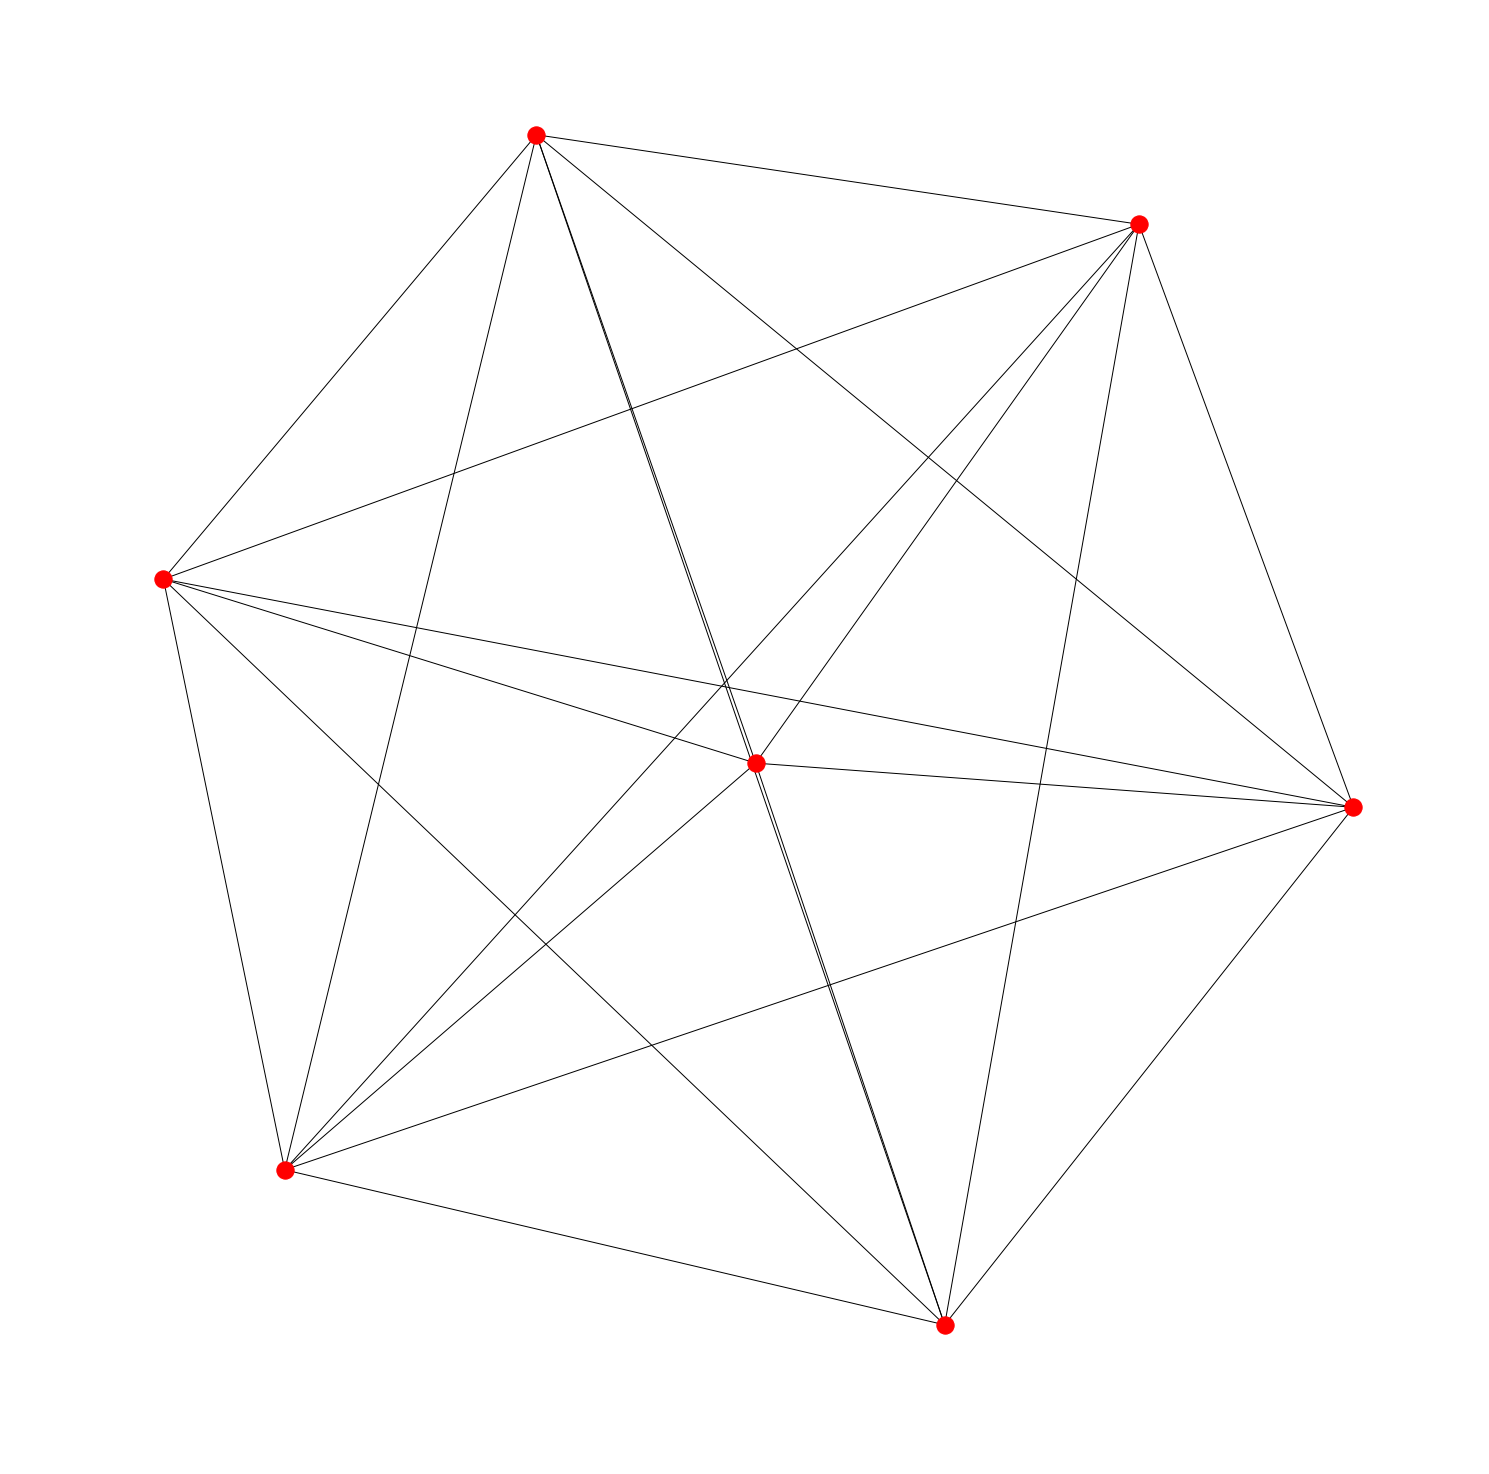

In [97]:
plt.figure(figsize=(20,20))
nx.draw_spring(G_ts.subgraph(cliques[0]))

In [47]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\Ronan Perry\Anaconda3\pkgs\proj4-5.1.0-hfa6e2cd_1\Library\share'
from mpl_toolkits.basemap import Basemap

In [45]:
lats,lons,names,sizes = [],[],[],[]
for biz in GCC.nodes:
    lookup = business_df[business_df['business_id'] == biz]
    names.append(lookup['name'])
    lons.append(float(lookup['longitude']))
    lats.append(float(lookup['latitude']))
    sizes.append(1)#GCC.degree[biz])

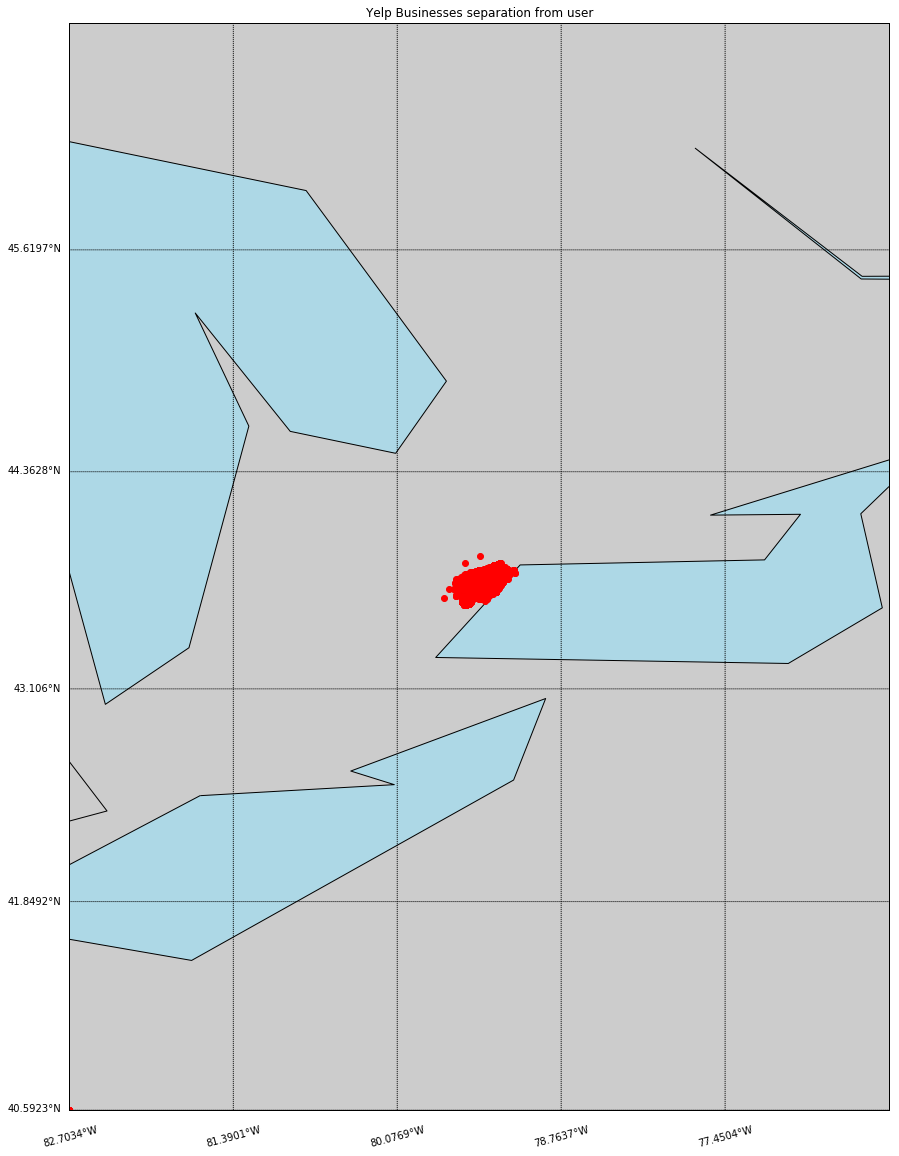

In [48]:
# How much to zoom from coordinates (in degrees)
zoom_scale = 3

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(20,20))
plt.title("Yelp Businesses separation from user")
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10)

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
m.drawmapboundary(fill_color='lightblue')

# plot elevations with different colors using the numpy interpolation mapping tool
# the range [50,200] can be changed to create different colors and ranges
for ii in range(0,len(names)):
    x,y = m(lons[ii],lats[ii])
    plt.plot(x,y,3,marker='o',color='red')
    
for e1,e2 in GCC.edges:
    x1,y1 = m(float(business_df[business_df['business_id']==e1]['longitude']),float(business_df[business_df['business_id']==e1]['latitude']))
    x2,y2 = m(float(business_df[business_df['business_id']==e2]['longitude']),float(business_df[business_df['business_id']==e2]['latitude']))
    plt.plot([x1, x2],[y1, y2],color='black')

In [268]:
cliques = list(nx.find_cliques(G_ts))

In [285]:
for a,b in GCC.edges:
    print(a,b)
    break

glkEaoxbewiSMBiXs945JA vHz2RLtfUMVRPFmd7VBEHA
